Import data from csv files to dataframe objects

In [1]:
import pandas as pd
import numpy as np
from pandasql import sqldf


# Import CSV
data_articleconc = pd.read_csv (r"articleconcepts.csv")   
df_articleconc = pd.DataFrame(data_articleconc)
df_articleconc['datesubmitted'] = pd.to_datetime(df_articleconc['datesubmitted']) # change datesubmitted column to datetime type

data_articleidtotals = pd.read_csv (r"articleidtotals.csv")   
df_articleidtotals = pd.DataFrame(data_articleidtotals)
df_articleidtotals['lastdate'] = pd.to_datetime(df_articleidtotals['lastdate']) # change datesubmitted column to datetime type

data_conc = pd.read_csv (r"concepts.csv")   
df_conc = pd.DataFrame(data_conc)


print(df_articleconc[:3])

   articleid  conceptid  totaltf       datesubmitted
0    1080366        853        1 1986-04-25 15:39:49
1    1080366       1514        1 1986-04-25 15:39:49
2    1080366       2992        1 1986-04-25 15:39:49


In [2]:
print(df_articleidtotals[:3])

   totalsid   lastdate
0      6594 1994-04-25
1      6975 1994-05-25
2      7417 1994-06-25


In [3]:
print(df_conc[:3])

   id  basic              mainname
0   1   True  ScienceWISE Ontology
1   3  False        Effective mass
2   4  False        Einstein solid


In [4]:
# check how many records are in the dataset 
# and if we have any NA

df_articleconc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30901668 entries, 0 to 30901667
Data columns (total 4 columns):
 #   Column         Dtype         
---  ------         -----         
 0   articleid      int64         
 1   conceptid      int64         
 2   totaltf        int64         
 3   datesubmitted  datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 943.0 MB


Data cleaning

In [5]:
df_articleconc.isnull().sum()

articleid        0
conceptid        0
totaltf          0
datesubmitted    0
dtype: int64

In [6]:
df_articleidtotals.isnull().sum()

totalsid    0
lastdate    0
dtype: int64

In [7]:
df_conc.isnull().sum()

id          0
basic       0
mainname    0
dtype: int64

Find duplicates in table 'concepts' mainname and value counts on 'basic' column

In [8]:
df_conc.value_counts(["basic"]) # we have more non-basic concepts in our database

basic
False    20716
True       375
dtype: int64

In [9]:
# Ensure that we have all dictinct names for the concepts id

duplicated_id = df_conc['id'].duplicated()
duplicated_name = df_conc['mainname'].duplicated() 
print("Count duplicated concepts id:", duplicated_id.sum()) 
print("Count duplicated names for concepts:", duplicated_name.sum())

Count duplicated concepts id: 0
Count duplicated names for concepts: 0


It is necessary to check if any of the concepts present in table 'concepts' has zero total frequency in table 'articleconcepts'

In [10]:
difference = len(df_conc.groupby('id'))-len(df_articleconc.groupby('conceptid'))
print(difference)

4721


To work only with concepts that where mentioned in the papers we will join the tables 'articleconcepts' and 'concepts' on concepts ID.

In [11]:
# concepts that we will exclude from further analysis can be found using the left outer join with python
import pandas as pd
non_matched_concepts = pd.merge(df_conc, df_articleconc, left_on =['id'], right_on=['conceptid'], how="outer", indicator=True
              ).query('_merge=="left_only"')
non_matched_concepts[['id', 'basic','mainname']]

,id,basic,mainname
0,1,True,ScienceWISE Ontology
14180,8,False,Electroacoustic phenomena
14935,17,False,Gough-Joule effect
20027,46,False,Timeline of the Big Bang
26127,62,False,Timeline of cosmology
...,...,...,...
30906381,204424,False,Turbulence_1
30906382,204425,False,Cross validation_1
30906383,204426,False,Cross validation_2
30906384,204427,False,Over-Complete Local Binary Patterns


In [12]:
# concepts that will be analysed

df_matched_concepts = pd.merge(df_conc, df_articleconc, left_on =['id'], right_on=['conceptid'], how="inner")
df_selected_articleconcepts = df_matched_concepts[['conceptid','totaltf','datesubmitted', 'basic','mainname','articleid']]

In [13]:
# save prepared dataframe in Feather format 
import pyarrow.feather as feather

df_selected_articleconcepts.reset_index().to_feather('df_selected_articleconcepts.feather')

df_selected_articleconcepts = pd.read_feather('df_selected_articleconcepts.feather')
#df_selected_articleconcepts.set_index('conceptid', inplace=True)
df_selected_articleconcepts.tail()

,index,conceptid,totaltf,datesubmitted,basic,mainname,articleid
30901663,30901663,204415,1,2018-06-11 17:46:51,False,Transformation group,1510135
30901664,30901664,204415,1,2018-06-26 13:55:11,False,Transformation group,1534708
30901665,30901665,204428,1,2018-06-11 00:00:00,False,Lepton jet,1392990
30901666,30901666,204428,6,2018-06-14 00:00:00,False,Lepton jet,1588240
30901667,30901667,204428,1,2018-06-22 00:00:00,False,Lepton jet,1592873


Some of the concepts has very low appearance in the scientific documents so we find those concepts and remove them from the dataset to

groped = df_articleconc.groupby('conceptid')
filtered = groped.apply(lambda g: g[g['totaltf'] == 1])
print(filtered)

Define a function to calculate the entropy of a concept within selected time interval

In [14]:
from datetime import date

def c_entropy(concept_id: int, start_date:date, end_date:date, df) -> int:

    """Calculate the entropy of the concept for a given time interval."""

    rslt_df = df[(df['conceptid'] == concept_id) & (df['datesubmitted'] > start_date) & (df['datesubmitted'] <= end_date)]
    uniq_totaltf=rslt_df['totaltf'].value_counts(normalize=True, ascending =True,sort =True,).to_dict()
    elem_entropy=[x*np.log2(x) for x in uniq_totaltf.values()]
    shannon_entropy=-sum(elem_entropy)

    return(shannon_entropy)



In [15]:
# test of the c_entropy function
c_entropy(1514, '2000-6-1', '2000-6-30', df_selected_articleconcepts)

2.136380250260913

Create routine for the entropy time series calculations for selected concept

In [16]:
end_dates = pd.date_range('2001-10-25', '2018-06-25',freq='m')#. to_pydatetime(). tolist()
ts = [c_entropy(1514, '2000-6-1',x, df_selected_articleconcepts) for x in end_dates]

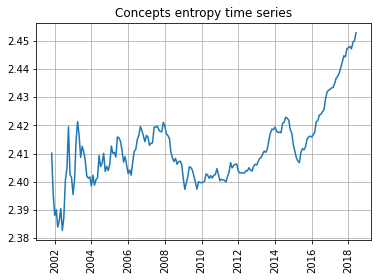

In [17]:
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import plotly.express as px 

plt.rc('font', size=10)
plt.plot_date(end_dates, ts, linestyle='-', fmt='-', label='Entropy')

# Giving title to the graph
plt.title('Concepts entropy time series')

# Setting axes

#plot = px.line()
plt.tick_params(axis='x', rotation=90)
plt.grid(True)

# Display

plt.show()

# alternative way to calculate the entropy using stats library 

import pandas as pd
import scipy
from scipy import stats

pd_series = pd.Series(df_selected_articleconcepts_interv['totaltf'])
counts = pd_series.value_counts()
entropy = scipy.stats.entropy(counts)

print(entropy)

Mutual entropy distance function 

In [18]:
from datetime import date
import math

def distance_entropy(left_concept: int, right_concept: int, start_date: date, end_date: date, df_data, df_totals) -> int:


    """Function to calculate mutual uinformation distance between a pair of concepts. Return symmetric measure of concepts similarity based of 
    concept or term frequency (TF). The input: concepts IDs in any order, period for distance calculation, dataframe with articleid, concept tf 
    and datesubmitted columns. To speed up calculation function needs additional dataframe with total number of articles published 
    up to an end_date. """

    start_date = '1986-04-25'
    end_date = '2018-04-25'

    # min_start_date = '1986-04-25' # first date in articleid total
    # max_end_date = '2018-04-25'  # last date in articleid total (actual last date is 2018-04-29 but we neglect 4 days for correct month slicing)
    left_concept = 266
    right_concept = 3545

    df = df_data # shorting name for the dataframe with relevant concepts and articles
    df_articleidtotals = df_totals

    a_total = df_articleidtotals[(df_articleidtotals['lastdate'] == end_date)].iloc[0]['totalsid'] # the number of distinct articles in the database before max_last_date
    # select data for the explicit conceptid and date range
    rslt_df_left = df[(df['conceptid'] == left_concept) & (df['datesubmitted'] >= start_date) & (df['datesubmitted'] <= end_date)][['articleid','totaltf']]
    rslt_df_right = df[(df['conceptid'] == right_concept) & (df['datesubmitted'] >= start_date) & (df['datesubmitted'] <= end_date)][['articleid','totaltf']]

    # total number of articles mention left or right concept
    a_total_c_left = len(rslt_df_left.value_counts('articleid'))
    a_total_c_right = len(rslt_df_right.value_counts('articleid'))

    # total number of articles that mention any of the concepts for that we use analog of SQL UNION (Area X+ Area XY+ Area Y)
    a_total_c_right_and_left = pd.concat([rslt_df_left, rslt_df_right]).drop_duplicates('articleid')

    # number of articles in the database that not mention left or right concept
    a_total_not_c_left = a_total - a_total_c_left # Area 1 + Area Y
    a_total_not_c_right = a_total - a_total_c_right  # Area 1 + Area X

    # number of articles in the database that do not mention bouth left and right concept
    a_total_not_c_right_and_left = a_total - len(a_total_c_right_and_left) # Area 1

    # extract articles where both concepts A and B cite together (SQL inner join on two subsets)
    inner_group = pd.merge(rslt_df_left, rslt_df_right, on="articleid", how="inner") # Area XY
    # define a number of times each unique combination of TF for X and Y appears in articles
    prob_inner_group = inner_group.value_counts(["totaltf_x", "totaltf_y"], sort = True).to_frame('cond_prob_inner').reset_index()
    # we need to connect to the joint probability (P(x,y)) corresponding p(x) and p(y) values where x (left) and y (right) is not zero 
    prob_left = rslt_df_left.value_counts('totaltf').rename_axis("totaltf_x").to_frame('cond_prob_left').reset_index() # for p(x)
    prob_right = rslt_df_right.value_counts('totaltf').rename_axis("totaltf_y").to_frame('cond_prob_right').reset_index() # for p(y)

    # correspondence of TF value counts for P(X), P(Y) and P(X,Y)
    prob_join_X_XY_Y = pd.merge(pd.merge(prob_left,prob_inner_group,on="totaltf_x", how="inner"),prob_right,on='totaltf_y', how="inner")


    # extract articles where only concept A(x) is mentioned discarding the articles where both concepts cite together (SQL left join)
    left_group = pd.merge(rslt_df_left, rslt_df_right, on="articleid", how="left") # (x,y=0 and not zero) -> Area X and Area XY
    left_group_y_0 = left_group[left_group['totaltf_y'].isnull()] # (x,y=0) -> Area X
    # TF value counts for the x total frequency where y can be both NaN and not zero
    prob_left_group_with_not_nan = left_group.value_counts("totaltf_x", sort = True).rename_axis("totaltf_x").to_frame('cond_prob_left')
    # TF value counts for the x total frequency where y can be only NaN
    prob_left_group = left_group_y_0.value_counts("totaltf_x", sort = True).rename_axis("totaltf_x").to_frame('cond_prob_left')
    # the correspondence of tf = x value counts for collection of articles where joint probabily p(x,y=0) - right column and p(x) - left column 
    prob_joint_y0_simple_x_any = pd.merge(prob_left_group_with_not_nan, prob_left_group, on="totaltf_x", how="inner") 


    # extract articles where only concept B(y) is mentioned discarding the articles where both concepts cite together (right join)
    right_group = pd.merge(rslt_df_left, rslt_df_right, on="articleid", how="right") # (x=0 and not zero, y ) -> Area Y and Area XY
    right_group_x_0 = right_group[right_group['totaltf_x'].isnull()]# (x=0,y) -> Area Y
    # data for the y total frequency where x can be both NaN and not zero
    prob_right_group_with_not_nan = right_group.value_counts("totaltf_y", sort = True).rename_axis("totaltf_y").to_frame('cond_prob_right')
    # data for the y total frequency where x can be only NaN
    prob_right_group = right_group_x_0.value_counts("totaltf_y", sort = True).rename_axis("totaltf_y").to_frame('cond_prob_right')
    # counts for every possible y value for joint probabily p(x=0,y) - right column and p(y) - left column 
    prob_joint_x0_simple_y_any = pd.merge(prob_right_group_with_not_nan, prob_right_group, on="totaltf_y", how="inner") 


    # the way to apply function to the row in the dataframe https://www.skytowner.com/explore/applying_a_function_that_takes_as_input_multiple_column_values_in_pandas

    # MUTUAL INFIORMATION for a pair of concepts is a sum over x and y in the expression P(X,Y)log(2, P(X,Y)/p(X)P(Y)) so we select four terms

    n00 = a_total_not_c_right_and_left # introduce a short notation for a variable (number of articles where both concepts have zero TF)
    # first term of the sum for X=0 and Y=0
    mutual_inf_00 = (n00/a_total) * math.log2((n00*a_total)/(a_total_not_c_left* a_total_not_c_right))

    # part of the sum for non-zero values of X and Y in mutual information
    mutual_inf_xy = prob_join_X_XY_Y.apply(lambda row: (row['cond_prob_inner']/a_total)*math.log2((row['cond_prob_inner']*a_total)/(row['cond_prob_left']*row['cond_prob_right'])), axis=1).sum()

    # part of the sum for non-zero values of X and Y=0 in mutual information
    mutual_inf_x0 = prob_joint_y0_simple_x_any.apply(lambda row: (row['cond_prob_left_y']/a_total)*math.log2((row['cond_prob_left_y']*a_total)/(row['cond_prob_left_x']*a_total_not_c_right)), axis=1).sum()

    # part of the sum for X=0 and non-zero values of Y in mutual information
    mutual_inf_0y = prob_joint_x0_simple_y_any.apply(lambda row: (row['cond_prob_right_y']/a_total)*math.log2((row['cond_prob_right_y']*a_total)/(row['cond_prob_right_x']*a_total_not_c_left)), axis=1).sum()

    # final value for all element of the sum
    mi = mutual_inf_00+mutual_inf_xy+mutual_inf_x0+mutual_inf_0y

    # MUTUAL ENTROPY for a pair of concepts is a sum over x and y in the expression P(X,Y)log(2, P(X,Y)) we divide its calculation in four parts

    # part where both X and Y are zero
    mutual_entropy_00 = (n00/a_total) * math.log2(n00/a_total)

    # part where both X and Y are not zero
    mutual_entropy_xy = prob_join_X_XY_Y.apply(lambda row: (row['cond_prob_inner']/a_total)*math.log2(row['cond_prob_inner']/a_total), axis=1).sum()

    # part where Y=0 and X any value
    mutual_entropy_x0 = prob_joint_y0_simple_x_any.apply(lambda row: (row['cond_prob_left_y']/a_total)*math.log2(row['cond_prob_left_y']/a_total), axis=1).sum()

    # part where X=0 and Y any value
    mutual_entropy_0y = prob_joint_x0_simple_y_any.apply(lambda row: (row['cond_prob_right_y']/a_total)*math.log2(row['cond_prob_right_y']/a_total), axis=1).sum()

    h_mutual_entropy = -(mutual_entropy_00 + mutual_entropy_xy + mutual_entropy_x0 + mutual_entropy_0y)

    # mutual information distance
    distMI = 1 - (mi/h_mutual_entropy)



    return(distMI)

Triangle inequality check for the mutual information distance

In [19]:
distance_entropy(266, 3545, '1986-04-25', '2018-04-25', df_selected_articleconcepts, df_articleidtotals)<distance_entropy(266, 1415, '1986-04-25', '2018-04-25', df_selected_articleconcepts, df_articleidtotals)+distance_entropy(1415, 3545, '1986-04-25', '2018-04-25', df_selected_articleconcepts, df_articleidtotals)
distance_entropy(266, 3545, '1986-04-25', '2018-04-25', df_selected_articleconcepts, df_articleidtotals)+distance_entropy(266, 1415, '1986-04-25', '2018-04-25', df_selected_articleconcepts, df_articleidtotals)>distance_entropy(1415, 3545, '1986-04-25', '2018-04-25', df_selected_articleconcepts, df_articleidtotals)
distance_entropy(266, 3545, '1986-04-25', '2018-04-25', df_selected_articleconcepts, df_articleidtotals)<distance_entropy(1415, 3545, '1986-04-25', '2018-04-25', df_selected_articleconcepts, df_articleidtotals)+distance_entropy(266, 1415, '1986-04-25', '2018-04-25', df_selected_articleconcepts, df_articleidtotals)

True

Next we need to create a distance matrix. We have two options here: i - calculate total distance matrix for all availiable concepts, ii - calculate smaller distance matrix extracting concepts hypotetically close to certain seed concept. First option needs more computational resources so we will use a second option. For this we have to select a list of concepts that will be used to calculate distances. Selecting the approximate topic concepts we find a resulting distance matrix and then filtering the largest distances to find a core of a topic.

Testing the parallel processing in Python

In [20]:
import multiprocessing
import numpy as np
from itertools import combinations
from functools import partial

hort_test_concepts = df_selected_articleconcepts['conceptid'].unique() # unique concepts in the database - need to code a selection of topic
short_test_conepts_10 = hort_test_concepts[:5] # the sample list of concepts

res_lst = sorted(map(sorted, combinations(set(short_test_conepts_10), 2))) # the list of unique tuples of concepts

# def myfunc(p):
    #product_of_list = np.prod(p)
    #return product_of_list
# distance_entropy(266, 3545, '1986-04-25', '2018-04-25', df_selected_articleconcepts, df_articleidtotals)

def parallel_runs(data_list):
    pool = multiprocessing.Pool(processes=4)
    prod_x=partial(distance_entropy, start_date = '1986-04-25', end_date = '2018-04-25', df_data = df_selected_articleconcepts, df_totals = df_articleidtotals) #prod_x has only one argument x (y is fixed to 10)
    result_list = pool.map(prod_x, res_lst)
    print(result_list)

if __name__ == '__main__':
    parallel_runs(res_lst)
    #pool = multiprocessing.Pool(processes=10)
    #result_list = pool.map(myfunc, res_lst)
    #print(result_list[:10])

TypeError: distance_entropy() missing 1 required positional argument: 'right_concept'

In [ ]:
import multiprocessing
from functools import partial
data_list = [1,2,3,4]

def prod_xy(x,y):
    return x * y

def parallel_runs(data_list):
    pool = multiprocessing.Pool(processes=4)
    prod_x=partial(prod_xy, y=10) #prod_x has only one argument x (y is fixed to 10)
    result_list = pool.map(prod_x, data_list)
    print(result_list)

if __name__ == '__main__':
    parallel_runs(data_list)

[10, 20, 30, 40]
